In [59]:
import sys
sys.path.append('../libraries/')
sys.path.append('results/')

import pandas as pd
import matplotlib.pyplot as plt
import shap
import model_tools as mt 

from shap import KernelExplainer, Explanation

import os

Model loaded from redflag_model_2024-10-18T14_28_09_548540.pkl


Using 198 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/198 [00:00<?, ?it/s]

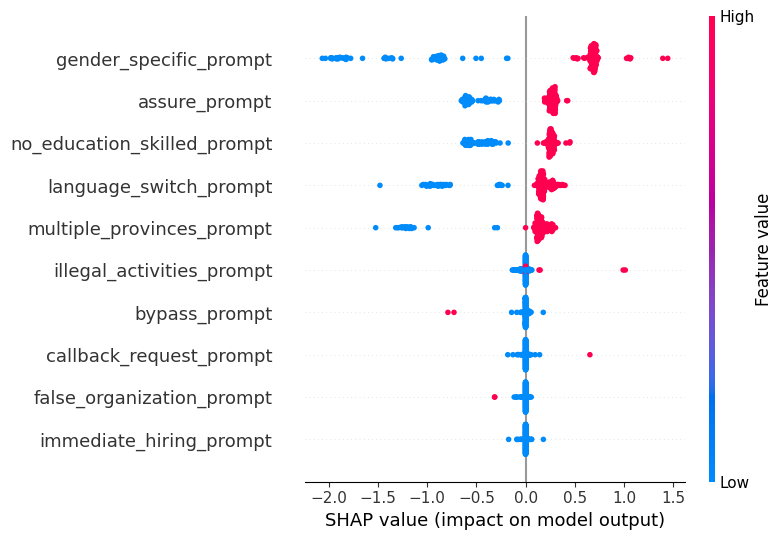

TypeError: float() argument must be a string or a number, not 'NoneType'

<Figure size 640x480 with 0 Axes>

In [66]:
os.chdir('/Users/christostrydom/github_repos/tinyhands/application/lji_social_media/')

DATA_COLUMNS = [
    "assure_prompt",
    "bypass_prompt",
    "callback_request_prompt",
    "false_organization_prompt",
    "gender_specific_prompt",
    "illegal_activities_prompt",
    "immediate_hiring_prompt",
    "language_switch_prompt",
    # "multiple_applicants_prompt",
    # "multiple_jobs_prompt",
    "multiple_provinces_prompt",
    "no_education_skilled_prompt",
    "no_location_prompt",
    "quick_money_prompt",
    "recruit_students_prompt",
    # "requires_references",
    "suspicious_email_prompt",
    "target_specific_group_prompt",
    "unprofessional_writing_prompt",
    "unrealistic_hiring_number_prompt",
    "unusual_hours_prompt",
    "vague_description_prompt",
    "wrong_link_prompt",
]


def load_and_preprocess_data(file_path):
    """
    Load and preprocess the dataset from the provided file path.
    """
    model_data = pd.read_csv(file_path)
    model_data = model_data[
        (model_data["monitor_score"] != "unknown")
        & (~model_data["monitor_score"].isna())
    ]
    mapping = {"yes": 1, "no": 0}
    model_data = model_data.replace(mapping)
    for col in DATA_COLUMNS:
        model_data[col] = pd.to_numeric(model_data[col], errors="coerce")

        # Now, you can identify and handle NaN values
        non_numeric_entries = model_data[model_data[col].isna()]
        model_data = model_data.dropna(subset=[col])
        model_data[col] = model_data[col].astype(int)

    return model_data, model_data["monitor_score"]



# Load your saved model
unique_model_filename = "redflag_model_2024-10-18T14_28_09_548540.pkl"  # Update with the actual filename
trained_pipeline = mt.load_model(unique_model_filename)

file_path = "results/advert_flags.csv"
advert_flags, y = load_and_preprocess_data(file_path)
X = advert_flags[DATA_COLUMNS]

# If your model contains any preprocessing steps (like data transformation), ensure you transform the data accordingly
X_transformed = trained_pipeline[:-1].transform(X)  # Assuming the last step is the model, we skip it

# Convert transformed data to a DataFrame for SHAP compatibility
X_transformed_df = pd.DataFrame(X_transformed, columns=X.columns[:X_transformed.shape[1]])

# Initialize SHAP KernelExplainer with the model and the transformed dataset
explainer = KernelExplainer(trained_pipeline[-1].predict, X_transformed_df)

# Calculate SHAP values for the entire dataset
shap_values = explainer.shap_values(X_transformed_df, nsamples=100)

# Plot SHAP summary plot for the entire dataset
plt.figure()
shap.summary_plot(shap_values, X_transformed_df)

# If you want to analyze individual predictions, pick a specific row (e.g., row 0)
instance_index = 0
shap_values_instance = shap_values[instance_index]

# Plot a SHAP waterfall plot for an individual instance
plt.figure()
shap.plots.waterfall(shap.Explanation(values=shap_values_instance, feature_names=X_transformed_df.columns), max_display=20)

# Show the plots
plt.show()

In [86]:
advert_flags.iloc[3]

advert                              (NEW) Municipality | General Worker: Water Sec...
group_id                                                                       570622
IDn                                                                            573227
monitor_score                                                                       9
assure_prompt                                                                       1
bypass_prompt                                                                       1
callback_request_prompt                                                             0
false_organization_prompt                                                           0
gender_specific_prompt                                                              0
illegal_activities_prompt                                                           0
immediate_hiring_prompt                                                             0
language_switch_prompt                                

In [75]:
advert_flags

,advert,group_id,IDn,monitor_score,assure_prompt,bypass_prompt,callback_request_prompt,false_organization_prompt,gender_specific_prompt,illegal_activities_prompt,...,quick_money_prompt,recruit_students_prompt,requires_references,suspicious_email_prompt,target_specific_group_prompt,unprofessional_writing_prompt,unrealistic_hiring_number_prompt,unusual_hours_prompt,vague_description_prompt,wrong_link_prompt
0,"""Can i have two flying fish and a Savanah for ...",572554,573194,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,# Road Cleaners Is Looking For General Workers...,570622,573339,7,1,1,1,0,0,0,...,0,0,0,0,1,1,1,1,1,1
2,# SASOL IS LOOKING FOR WORKERS & CLEANERS# Sal...,572542,573449,9,1,1,1,1,0,0,...,0,0,0,0,0,1,0,0,1,1
3,(NEW) Municipality | General Worker: Water Sec...,570622,573227,9,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,482 092 Jobs openPremier Panyaza Lesufi calls ...,572549,572550,4,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,We're Looking for Light Duty DriversApplicatio...,572582,572583,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
196,Wimpy is hiring Unemployed Youth to work as cl...,570622,572467,8,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1
197,Woolworth's is Hiring We're Taking CVs now in ...,570622,573311,8,1,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
198,Yet another blow to hopeful migrants. Those ho...,572526,572527,2,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0


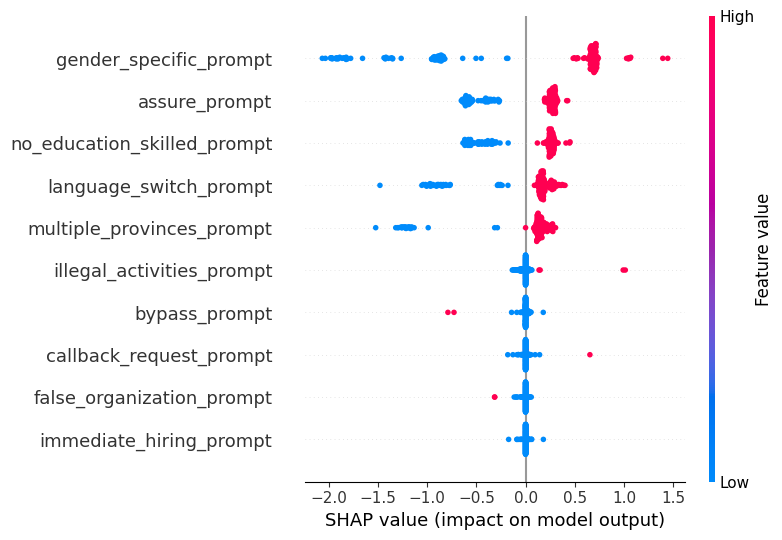

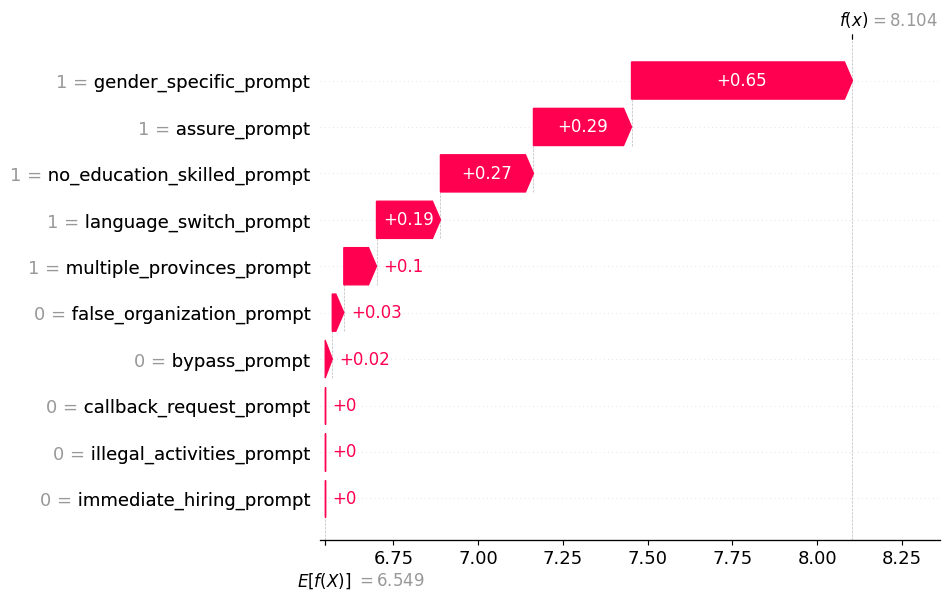

In [76]:
# Plot SHAP summary plot for the entire dataset
plt.figure()
shap.summary_plot(shap_values, X_transformed_df)

# If you want to analyze individual predictions, pick a specific row (e.g., row 0)
instance_index = 3
shap_values_instance = shap_values[instance_index]

# Create an Explanation object for the individual instance
shap_values_instance_explanation = Explanation(
    values=shap_values_instance,
    base_values=explainer.expected_value,
    data=X_transformed_df.iloc[instance_index],
    feature_names=X_transformed_df.columns
)

# Plot a SHAP waterfall plot for an individual instance
plt.figure()
shap.plots.waterfall(shap_values_instance_explanation, max_display=20)

# Show the plots
plt.show()

In [77]:
# Extract feature importances (mean absolute SHAP values)
feature_importances = pd.DataFrame({
    'Feature': X_transformed_df.columns,
    'Importance': abs(shap_values).mean(axis=0)
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances)

Feature Importances:
                       Feature  Importance
4       gender_specific_prompt    0.898658
0                assure_prompt    0.356254
9  no_education_skilled_prompt    0.338081
7       language_switch_prompt    0.315348
8    multiple_provinces_prompt    0.287469
5    illegal_activities_prompt    0.028924
1                bypass_prompt    0.017240
2      callback_request_prompt    0.011612
3    false_organization_prompt    0.010697
6      immediate_hiring_prompt    0.006740


In [78]:
# If you want to analyze individual predictions, pick a specific row (e.g., row 0)
instance_index = 3
shap_values_instance = shap_values[instance_index]

In [80]:
X.iloc[instance_index]

assure_prompt                       1
bypass_prompt                       1
callback_request_prompt             0
false_organization_prompt           0
gender_specific_prompt              0
illegal_activities_prompt           0
immediate_hiring_prompt             0
language_switch_prompt              0
multiple_provinces_prompt           0
no_education_skilled_prompt         0
no_location_prompt                  1
quick_money_prompt                  0
recruit_students_prompt             0
suspicious_email_prompt             0
target_specific_group_prompt        0
unprofessional_writing_prompt       1
unrealistic_hiring_number_prompt    0
unusual_hours_prompt                0
vague_description_prompt            1
wrong_link_prompt                   1
Name: 3, dtype: int64

In [81]:
X_transformed_df.iloc[instance_index]

assure_prompt                  1.0
bypass_prompt                  0.0
callback_request_prompt        0.0
false_organization_prompt      0.0
gender_specific_prompt         1.0
illegal_activities_prompt      0.0
immediate_hiring_prompt        0.0
language_switch_prompt         1.0
multiple_provinces_prompt      1.0
no_education_skilled_prompt    1.0
Name: 3, dtype: float64

In [82]:
# Create an Explanation object for the individual instance
shap_values_instance_explanation = Explanation(
    values=shap_values_instance,
    base_values=explainer.expected_value,
    data=X_transformed_df.iloc[instance_index],
    feature_names=X_transformed_df.columns
)

In [83]:
print(X_transformed_df.loc[2])

assure_prompt                  1.0
bypass_prompt                  0.0
callback_request_prompt        0.0
false_organization_prompt      0.0
gender_specific_prompt         1.0
illegal_activities_prompt      0.0
immediate_hiring_prompt        0.0
language_switch_prompt         1.0
multiple_provinces_prompt      1.0
no_education_skilled_prompt    1.0
Name: 2, dtype: float64


<Figure size 640x480 with 0 Axes>

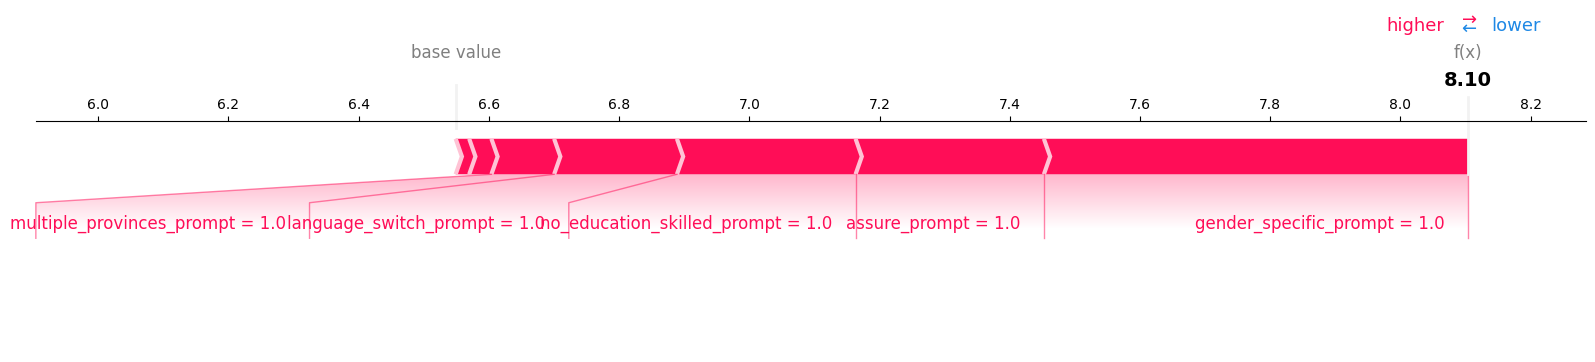

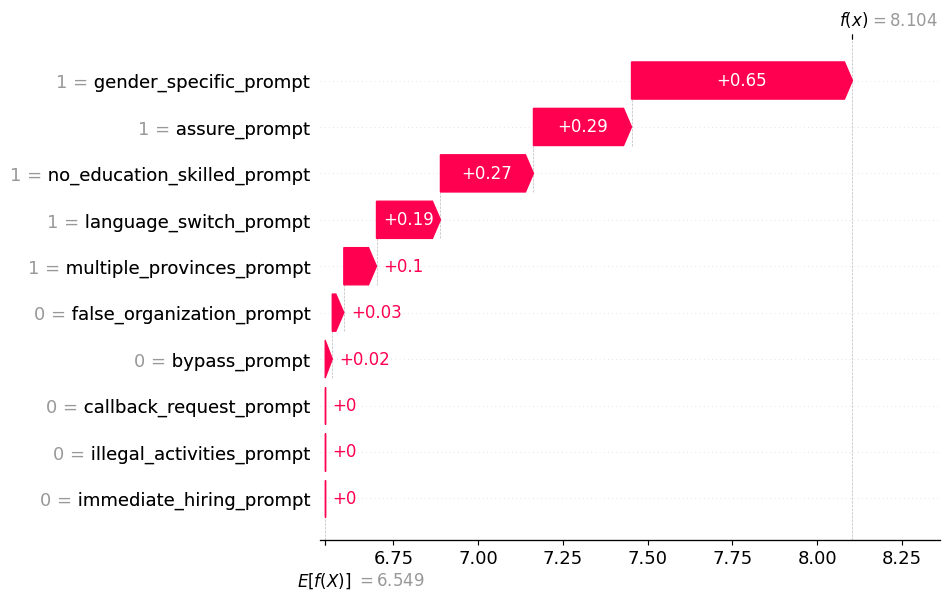

In [84]:
# Plot a SHAP force plot for an individual instance to show the contribution of each feature to the predicted score
plt.figure()
shap.force_plot(
    base_value=shap_values_instance_explanation.base_values,
    shap_values=shap_values_instance_explanation.values,
    features=shap_values_instance_explanation.data,
    feature_names=shap_values_instance_explanation.feature_names,
    matplotlib=True
)

# Plot a SHAP waterfall plot for an individual instance
plt.figure()
shap.plots.waterfall(shap_values_instance_explanation, max_display=20)

# Show the plots
plt.show()

In [54]:
X.loc[2]

assure_prompt                       1
bypass_prompt                       1
callback_request_prompt             1
false_organization_prompt           1
gender_specific_prompt              0
illegal_activities_prompt           0
immediate_hiring_prompt             0
language_switch_prompt              0
multiple_provinces_prompt           0
no_education_skilled_prompt         0
no_location_prompt                  1
quick_money_prompt                  0
recruit_students_prompt             0
suspicious_email_prompt             0
target_specific_group_prompt        0
unprofessional_writing_prompt       1
unrealistic_hiring_number_prompt    0
unusual_hours_prompt                0
vague_description_prompt            1
wrong_link_prompt                   1
Name: 2, dtype: int64

In [57]:
advert_flags.loc[advert_flags['illegal_activities_prompt']==1, ['illegal_activities_prompt', 'monitor_score']]

,illegal_activities_prompt,monitor_score
37,1,5
73,1,1
113,1,2


In [87]:
instance_index = 3  # Example index

print("Original value in X:", X.loc[instance_index, "gender_specific_prompt"])
print("Transformed value in X_transformed_df:", X_transformed_df.loc[instance_index, "gender_specific_prompt"])


Original value in X: 0
Transformed value in X_transformed_df: 1.0


In [89]:
raw_data = pd.read_csv("results/advert_flags.csv")
print("Raw data value for gender_specific_prompt:", raw_data.loc[instance_index, "gender_specific_prompt"])


Raw data value for gender_specific_prompt: no
